<font size=8> Network Tests


In [10]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio



@timeout_decorator.timeout(40)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
        
    )

<font size=7> Manual Tuning


In [11]:
[board,profile_path,number_of_chips]=obtain_board()

In [12]:

def calculate_slope(time_axis, ff_windows_sst):
    slope, intercept, r_value, p_value, std_err = linregress(time_axis, ff_windows_sst)
    return slope


In [13]:

neuron_config = neuron_configs_bio.config()

neuron_config['PC_Adaptation'] = True
neuron_config['duration'] = 15
neuron_config['input_type'] = 'Regular'
neuron_config['in_freq'] = 20
neuron_config['nvn'] = 15
neuron_config['pcn'] = 100
neuron_config['pvn'] = 20
neuron_config['sstn'] = 15


In [14]:
#create grid search parameters
param_grid = {
    'SST_W0': product([3,4],[10,50,100]),
    'SST_AMPA_GAIN': product([2,3], [10,100,150]),
    'SST_AMPA_TAU': product([1, 0], [10,100,150]),
    'SST_LEAK': product([0], [10,20,250]),
    'Input_SST': [.05, .1,.2],
    'PC_SST': [.05, .1,.2]
}

# Flatten the product for the parameters
expanded_param_grid = {
    key: list(value) for key, value in param_grid.items()
}

param_values = list(expanded_param_grid.values())
total_combinations = len(list(product(*param_values))) # Total number of parameter combinations

# Load previous results if available
try:
    with open('results_1.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []

# Determine the starting point based on the loaded results
start_point = len(results)

# Iterate through the parameter grid starting from the last completed simulation
for i, params in enumerate(product(*param_values), start=0):
    if i < start_point:
        continue  # Skip already completed simulations

    print(f"Running simulation {i+1}/{total_combinations}...")

    # Create a dictionary of the current parameter values, flattening product objects
    current_params = {
        key: (item[0], item[1]) if isinstance(item, tuple) else item
        for key, item in zip(expanded_param_grid.keys(), params)
    }

    # Update the values in neuron_config with the current parameter values
    neuron_config.update(current_params)

    try:
        [output_events, test_config] = run_simulation(neuron_config)
        fot_output= frequency_over_time(test_config, output_events)
        [time_axis, ff_windows_pc, ff_windows_pv, ff_windows_sst] = fot_output
        fvt_fig = frequency_vs_time_plot(frequency_over_time(test_config, output_events), test_config, save=True, annotate=True,neuron_config=neuron_config)
        slope = calculate_slope(time_axis, ff_windows_sst)
        results.append((current_params, slope))  # Storing the current_params instead of neuron_config
        # Save progress
        with open('results_1.pkl', 'wb') as f:
            results.append((current_params, slope))  # Storing the current_params instead of neuron_config
            pickle.dump(results, f)
    except timeout_decorator.TimeoutError:
        print("Simulation timed out, trying again with new parameters...")


print("Simulation completed")



Running simulation 1331/5832...
{'input_type': 'Regular', 'PC_Adaptation': True, 'STD': False, 'DC_Latches': False, 'overtake_test': False, 'decay': False, 'duration': 15, 'in_freq': 20, 'in_DC': 0, 'plot_iter': False, 'n_iter': 20, 'Striated': False, 'duration1': 300000, 'duration2': 300000, 'rest_time': 200000, 'core_to_measure': 0, 'synapse_to_measure': 'ampa', 'neuron_to_measure': 10, 'test_type': 'neuron', 'DC_pulse': [3, 250], 'sweep': False, 'sweep_variable': 'SYAM_STDW_N', 'sweep_coarse_val': 0, 'sweep_range_fine': array([  0,  62, 125, 187, 250]), 'DC_Coarse': 2, 'DC_FI_Range': array([  0,  27,  55,  83, 111, 138, 166, 194, 222, 250]), 'Freq_FI_Range:': array([  0,  27,  55,  83, 111, 138, 166, 194, 222, 250]), 'nvn': 15, 'pcn': 100, 'pvn': 20, 'sstn': 15, 'Input_PC': 0.3, 'Input_PV': 0.11, 'Input_SST': 0.2, 'PC_PC': 0.2, 'PC_PV': 0.15, 'PC_SST': 0.1, 'PV_PC': 0.2, 'PV_PV': 0.2, 'PV_SST': 0.2, 'SST_PC': 0.3, 'SST_PV': 0.2, 'PC_LEAK': [1, 46], 'PC_GAIN': [0, 30], 'PC_REF': [1, 

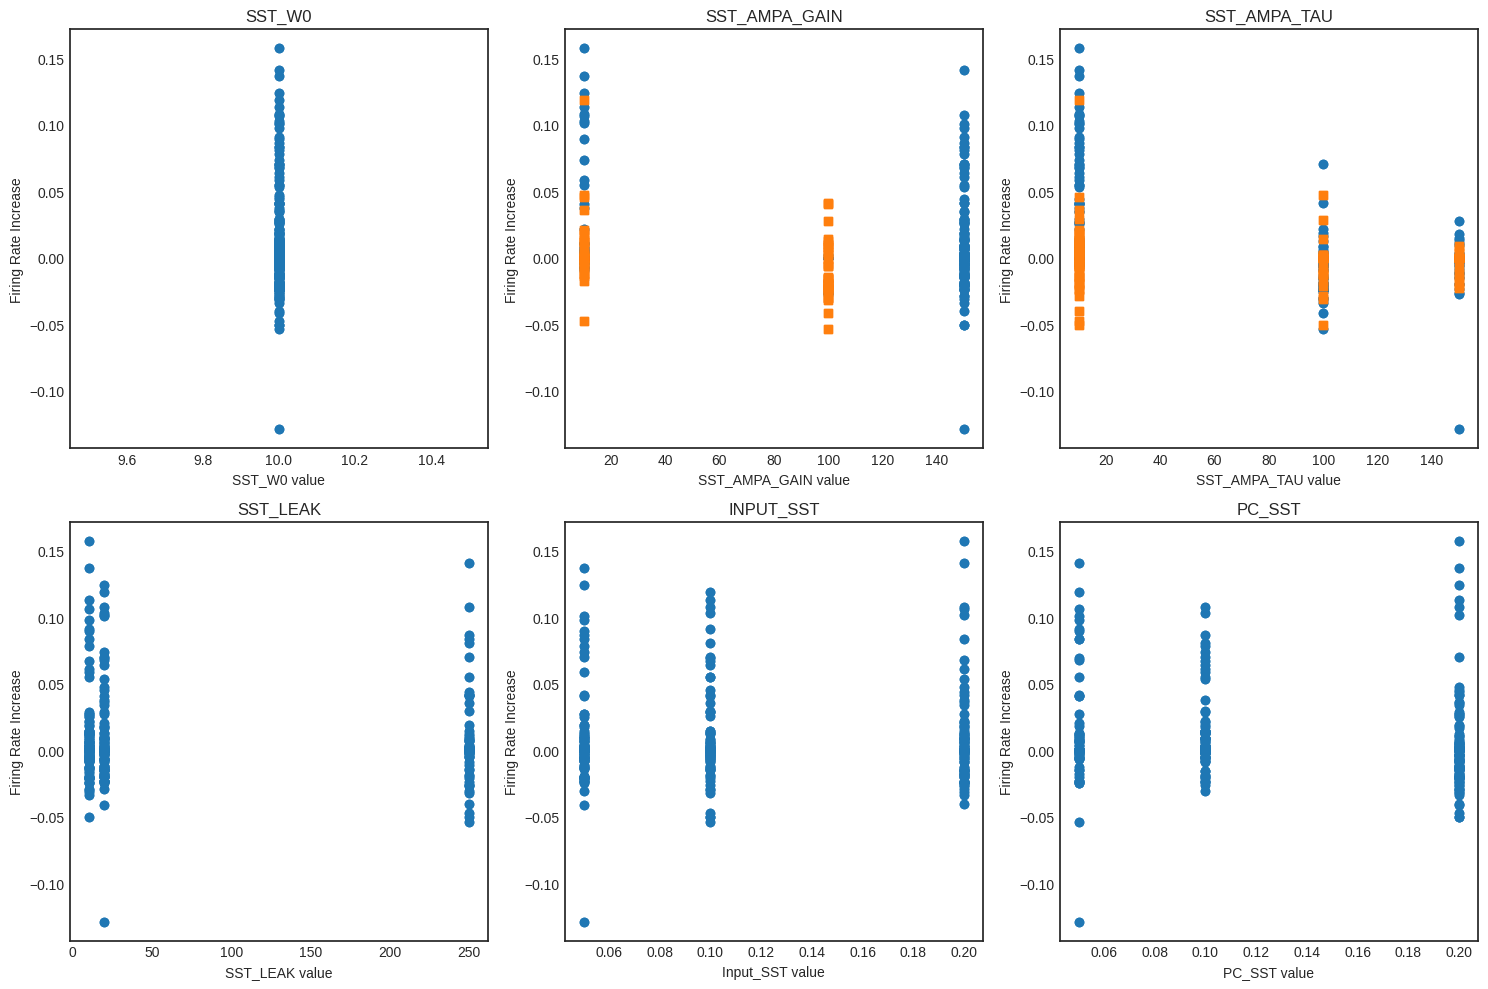

In [ ]:
import matplotlib.pyplot as plt

# Parameters for which you want to create subplots
parameters = ['SST_W0', 'SST_AMPA_GAIN', 'SST_AMPA_TAU', 'SST_LEAK', 'Input_SST', 'PC_SST']

# Define the number of subplots (2 rows and 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Define marker shapes
markers = ['o', 's', 'v', '^', '<', '>']

# Iterate through each parameter and create subplots
for i, param in enumerate(parameters):
    # If the parameter is not from the first four, there's no coarse value
    if param in ['SST_W0', 'SST_AMPA_GAIN', 'SST_AMPA_TAU', 'SST_LEAK']:
        unique_coarse_values = set([r[0][param][0] for r in results if param in r[0]])

        for j, coarse_value in enumerate(unique_coarse_values):
            # Filter the results for the current coarse value
            filtered_results = [(r[0][param][1], r[1]) for r in results if param in r[0] and r[0][param][0] == coarse_value]

            # Separate the fine values and the slopes
            fine_values, slopes = zip(*filtered_results)

            # Plot the data using different marker shapes for each coarse value
            axes[i].scatter(fine_values, slopes, label=f'Coarse value: {coarse_value}', marker=markers[j % len(markers)])
    else:
        # If the parameter is 'input_sst' or 'pc_sst', plot them directly
        values, slopes = zip(*[(r[0][param], r[1]) for r in results if param in r[0]])

        # Plot the data
        axes[i].scatter(values, slopes)

    axes[i].set_title(f'{param.upper()}')
    axes[i].set_xlabel(f'{param} value')
    axes[i].set_ylabel('Firing Rate Increase')

    # Add a legend to distinguish between different coarse values
    if param in ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak']:
        axes[i].legend()

plt.tight_layout()
plt.show()
